In [1]:
import glob

import numpy             as np
import matplotlib.pyplot as plt

from collections import defaultdict

from CCfun  import in_range
from CCfun  import filter_df
from CCfun  import longer_than_exwl
from CCfun  import find_crystal_position
from CCfun  import compute_baseline_float

from CCfit import fit
from CCfit import shifted_gauss

from CCplot import plot1d
from CCplot import plot2d
from CCplot import plot_line
from CCplot import auto_plot_style
from CCplot import figure_sizes
from CCplot import subplots
from CCplot import set_ylimits

from CCdatabase import paper_signals
from CCdatabase import californication_irradiation_mapping
from CCdatabase import position_correction

from CCio import load_all

In [2]:
%matplotlib inline

auto_plot_style()

In [3]:
%load_ext autoreload
%autoreload 2

# All data

In [4]:
filenames_pre  = glob.glob("/home/gonzalo/data/CC/Californication/*pre*.h5")
filenames_post = glob.glob("/home/gonzalo/data/CC/Californication/*post*.h5")
experiment     = load_all(filenames_pre, filenames_post)

In [5]:
experiment.pre.crystals.head()

looparound  crystal  grating  exp_index  slit_width  state  exposure  \
0       False        4        2          0        1000    114       0.1   
1       False        4        2          0        1000    114       0.1   
2       False        4        2          0        1000    114       0.1   
3       False        4        2          0        1000    114       0.1   
4       False        4        2          0        1000    114       0.1   

   ex_wl     power   em_wl  counts crystal_id crystal_type  bkgsub   rate  \
0  275.0  0.000008  287.75    3251  Sp_B2_036           Sp   -26.0 -260.0   
1  275.0  0.000008  288.25    3207  Sp_B2_036           Sp   -70.0 -700.0   
2  275.0  0.000008  288.75    3276  Sp_B2_036           Sp    -1.0  -10.0   
3  275.0  0.000008  289.50    3273  Sp_B2_036           Sp    -4.0  -40.0   
4  275.0  0.000008  290.00    3290  Sp_B2_036           Sp    13.0  130.0   

        quantar       dquanta  wheel_no  
0  1.105275e+15 -2.352357e-13         0  
1  1.105275e+15 -6.333268e-13         0  
2  1.105275e+15 -9.047526e-15         0  
3  1.105275e+15 -3.619010e-14         0  
4  1.105275e+15  1.176178e-13         0

In [6]:
experiment.post.crystals.head()

looparound  crystal  grating  exp_index  slit_width  state  exposure  \
0       False        5        2          0        1000    114       0.1   
1       False        5        2          0        1000    114       0.1   
2       False        5        2          0        1000    114       0.1   
3       False        5        2          0        1000    114       0.1   
4       False        5        2          0        1000    114       0.1   

   ex_wl     power   em_wl  counts crystal_id crystal_type  bkgsub    rate  \
0  275.0  0.000008  287.75    3396  Sp_B2_036           Sp   111.0  1110.0   
1  275.0  0.000008  288.25    3380  Sp_B2_036           Sp    95.0   950.0   
2  275.0  0.000008  288.75    3373  Sp_B2_036           Sp    88.0   880.0   
3  275.0  0.000008  289.50    3410  Sp_B2_036           Sp   125.0  1250.0   
4  275.0  0.000008  290.00    3379  Sp_B2_036           Sp    94.0   940.0   

        quantar       dquanta  wheel_no  
0  1.058061e+15  1.049089e-12         3  
1  1.058061e+15  8.978692e-13         3  
2  1.058061e+15  8.317104e-13         3  
3  1.058061e+15  1.181407e-12         3  
4  1.058061e+15  8.884179e-13         3

In [7]:
ex_wl = 600
em_wl = 770

In [8]:
sp039  = filter_df(experiment.pre.crystals, ex_wl=250  , grating=1, crystal_id="Sp_B2_039")
caf281 = filter_df(experiment.pre.crystals, ex_wl=ex_wl, grating=2, crystal_id="CaF_B1_281")
caf292 = filter_df(experiment.pre.crystals, ex_wl=ex_wl, grating=2, crystal_id="CaF_B1_292")
caf289 = filter_df(experiment.pre.crystals, ex_wl=ex_wl, grating=2, crystal_id="CaF_B1_289")
caf290 = filter_df(experiment.pre.crystals, ex_wl=ex_wl, grating=2, crystal_id="CaF_B1_290")

In [9]:
def do_fit(x, y, peak, *args, **kwargs):
    low  =                 0, peak - 200,      0, -1
    seed = y.max() - y.min(), peak      ,     50,  np.mean(y)
    upp  =            np.inf, peak + 200, np.inf, +1
    f    = fit(shifted_gauss, x, y, seed, *args, **kwargs,
               #bounds=(low, upp),
               maxfev=int(1e5))
    return f, seed


def sum_crystal(df, peak):
    df   = longer_than_exwl(df)
    x, y = df.em_wl.values, df.dquanta.values
    return y[in_range(x, peak - 300, peak + 300)].sum()


def fit_crystal(df, peak, fit_range=None, plot=False):
    if fit_range is None:
        fit_range = peak - 300, peak + 300
    df   = longer_than_exwl(df)
    x, y = df.em_wl.values, df.dquanta.values
    f, s = do_fit(x, y, peak, fit_range=fit_range)
    if plot:
        if "spectrum" in plot: plt.plot(x, y)
        if "fit"      in plot: plt.plot(x, f.fn(x))
        print(s)
        print(f.values)
        
    return f.values[0] / np.diff(x)[0], f.errors[0] / np.diff(x)[0]


def get_integrals(df, peak, fit_range=None):
    integrals = [[], []]
    errors    = [[], []]
    for looparound, loop in df.groupby("looparound"):
        looparound = int(looparound)
        datas = np.split(loop, len(loop)//1600)
        for data in datas:
            assert len(data.exposure.drop_duplicates()) == 1
            integral, error = fit_crystal(data, peak, fit_range)
            integrals[looparound].append(integral)
            errors   [looparound].append(error   )
    return np.array(integrals), np.array(errors)

def get_sums(df, peak):
    integrals = [[], []]
    errors    = [[], []]
    for looparound, loop in df.groupby("looparound"):
        looparound = int(looparound)
        datas = np.split(loop, len(loop)//1600)
        for data in datas:
            assert len(data.exposure.drop_duplicates()) == 1
            sum = sum_crystal(data, peak)
            integrals[looparound].append(sum)
            errors   [looparound].append(0)
    return np.array(integrals), np.array(errors)

(2.4701076477582797e-12, 770, 50, -2.342939936082672e-13)
[ 2.49411707e-10  7.56799250e+02  4.52368677e+01 -5.34048639e-13]
(2.4393494573942335e-12, 770, 50, 3.072982343112205e-13)
[ 2.61245645e-10  7.56939749e+02  4.53556367e+01 -6.40335962e-15]
(1.8088693511850505e-12, 770, 50, 3.3470997617075186e-13)
[2.51995251e-10 7.58775588e+02 5.20816247e+01 2.16716574e-14]
(2.5419714788890458e-12, 770, 50, -2.301337529787824e-13)
[ 2.50240251e-10  7.56852549e+02  4.52833458e+01 -5.32233188e-13]
(2.577983584256402e-12, 770, 50, -2.254925212517635e-13)
[ 2.49642464e-10  7.56843203e+02  4.51635356e+01 -5.25397185e-13]
(2.502831642970353e-12, 770, 50, -2.282781425265199e-13)
[ 2.49754606e-10  7.56980009e+02  4.51977224e+01 -5.29166082e-13]
(2.5267941552708263e-12, 770, 50, -2.202428850547818e-13)
[ 2.51362750e-10  7.56649047e+02  4.51361395e+01 -5.23830196e-13]
(2.411223975396033e-12, 770, 50, 3.0762098984499566e-13)
[ 2.61790973e-10  7.56996508e+02  4.54774005e+01 -7.08444029e-15]
(2.4387276034927

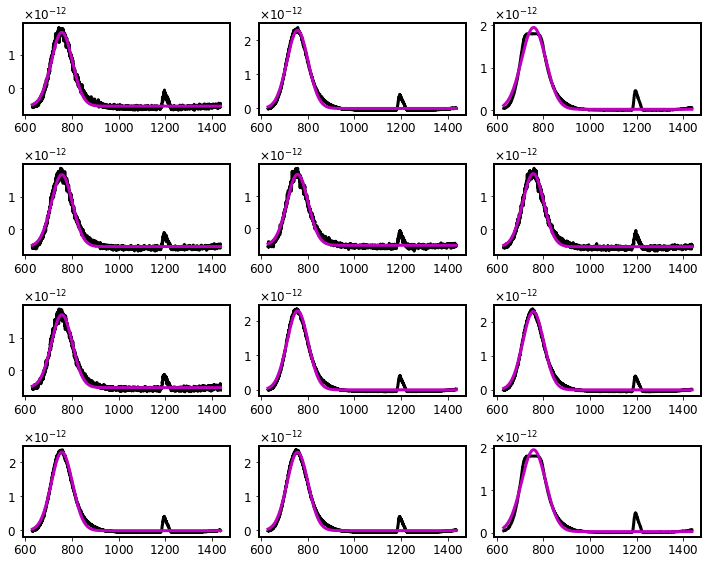

In [10]:
dfs = filter_df(caf281, looparound=False)

for k, df in enumerate(np.split(dfs, len(dfs)//1600), start=1):
    plt.subplot(4, 3, k)
    fit_crystal(df, em_wl, plot="spectrum fit")

plt.tight_layout()

(3.3654666145103836e-13, 770, 50, 2.5397972140625128e-14)
[1.50089407e-11 7.57846806e+02 4.51741514e+01 4.79214198e-15]
(1.6470131907183258e-13, 770, 50, 2.1480890632739846e-14)
[1.51814073e-11 7.57089049e+02 4.43509003e+01 3.31327934e-15]
(1.5581581197889092e-13, 770, 50, 2.0975348152843505e-14)
[1.60193490e-11 7.57370475e+02 4.49742407e+01 1.51688502e-15]


Text(0, 0.5, 'quanta out / quanta in')

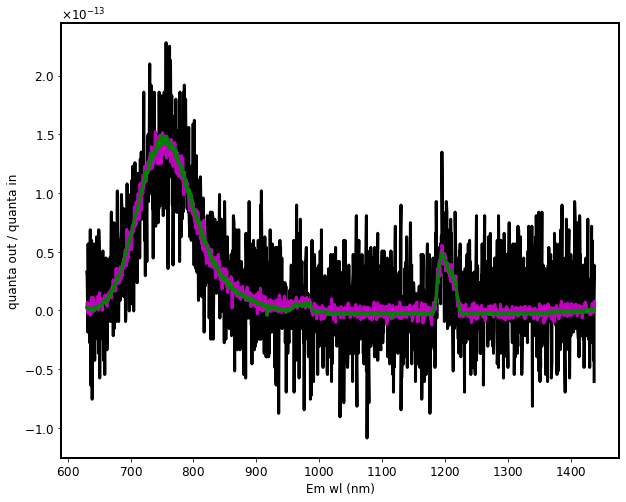

In [11]:
dfs = filter_df(caf290, looparound=False, ex_wl=ex_wl, grating=2)

for df in np.split(dfs, len(dfs)//1600)[:3]:
    df          = df.copy()
    df.dquanta -= compute_baseline_float(df.dquanta)
    fit_crystal(df, em_wl, plot="spectrum")

plt.xlabel("Em wl (nm)")
plt.ylabel("quanta out / quanta in")

(3.3654666145103836e-13, 770, 50, 2.5397972140625128e-14)
[1.50089407e-11 7.57846806e+02 4.51741514e+01 4.79214198e-15]
(1.6470131907183258e-13, 770, 50, 2.1480890632739846e-14)
[1.51814073e-11 7.57089049e+02 4.43509003e+01 3.31327934e-15]
(1.5581581197889092e-13, 770, 50, 2.0975348152843505e-14)
[1.60193490e-11 7.57370475e+02 4.49742407e+01 1.51688502e-15]


Text(0, 0.5, 'quanta out / quanta in')

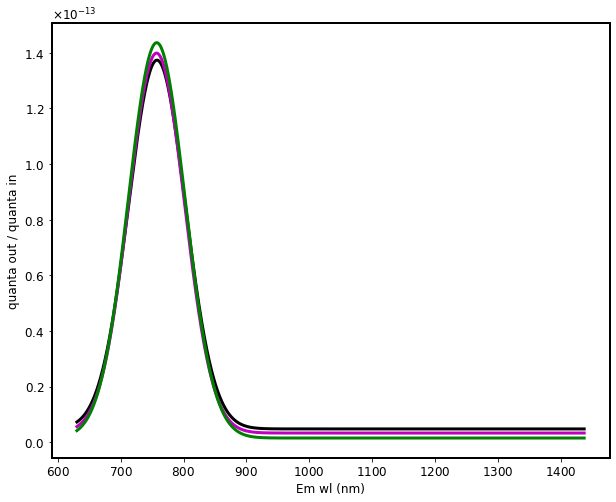

In [12]:
dfs = filter_df(caf290, looparound=False, ex_wl=ex_wl, grating=2)

for df in np.split(dfs, len(dfs)//1600)[:3]:
    df          = df.copy()
    df.dquanta -= compute_baseline_float(df.dquanta)
    fit_crystal(df, em_wl, plot="fit")


plt.xlabel("Em wl (nm)")
plt.ylabel("quanta out / quanta in")

Text(0, 0.5, 'peak integral')

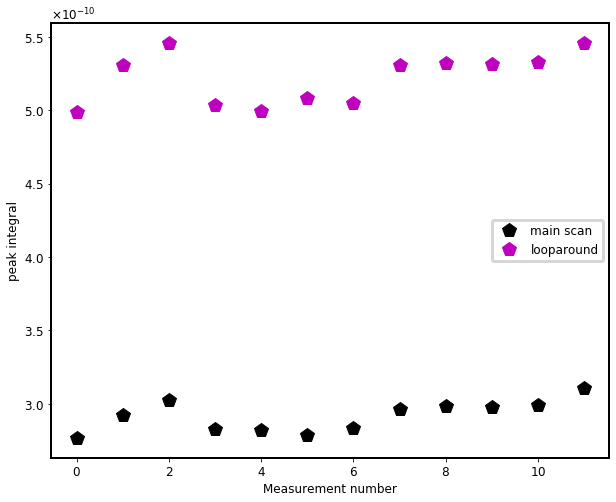

In [13]:
ii, ee = get_integrals(sp039, 350)

for i, label in zip(ii, ("main scan", "looparound")):
    plt.plot(i, "p", label=label)

plt.legend(loc="center right")
plt.xlabel("Measurement number")
plt.ylabel("peak integral")

Text(0, 0.5, 'peak integral')

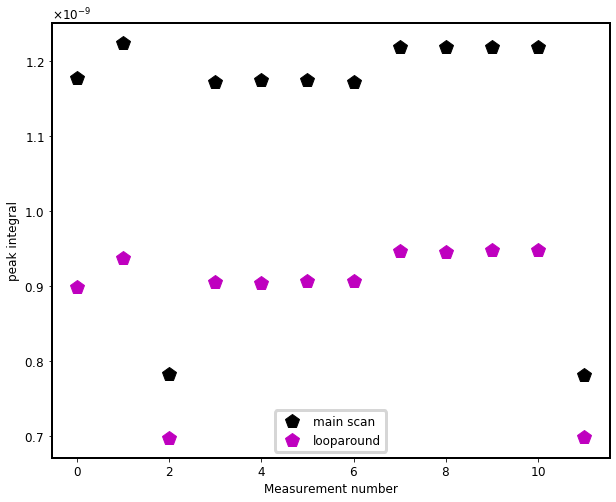

In [14]:
ii, ee = get_integrals(caf289, em_wl)

for i, label in zip(ii, ("main scan", "looparound")):
    plt.plot(i, "p", label=label)

plt.legend()
plt.xlabel("Measurement number")
plt.ylabel("peak integral")

Text(0, 0.5, 'peak integral or sum')

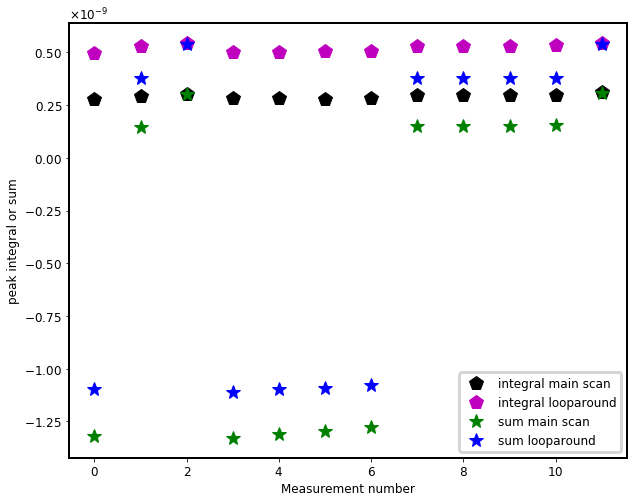

In [15]:
ii, ee = get_integrals(sp039, 350)
ss, __ = get_sums     (sp039, 350)

for i, label in zip(ii, ("main scan", "looparound")):
    plt.plot(i, "p", label="integral " + label)

for s, label in zip(ss, ("main scan", "looparound")):
    plt.plot(s, "*", label="sum " + label)

plt.legend()
plt.xlabel("Measurement number")
plt.ylabel("peak integral or sum")

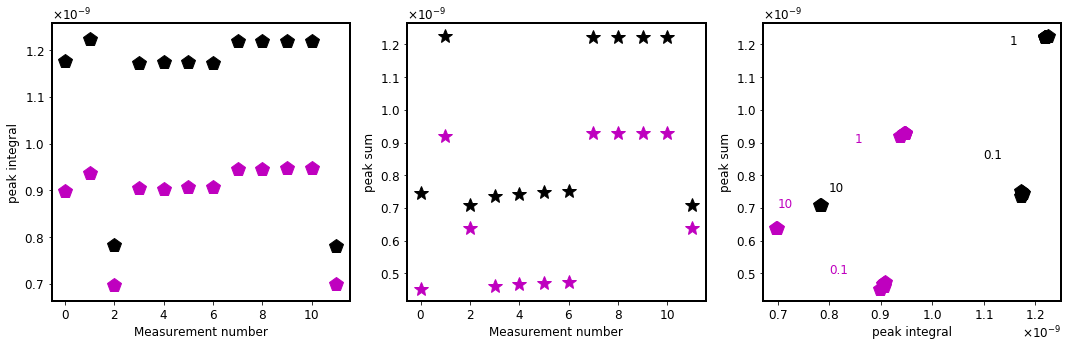

In [16]:
ii, ee = get_integrals(caf289, em_wl)
ss, __ = get_sums     (caf289, em_wl)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
for i, e in zip(ii, ee):
    plt.errorbar(np.arange(len(i)), i, e, fmt="p")

plt.xlabel("Measurement number")
plt.ylabel("peak integral")

plt.subplot(1, 3, 2)
for s in ss:
    plt.errorbar(np.arange(len(i)), s, fmt="*")

plt.xlabel("Measurement number")
plt.ylabel("peak sum")

plt.subplot(1, 3, 3)
for i, s in zip(ii, ss):
    plt.errorbar(i, s, fmt="p")

plt.xlabel("peak integral")
plt.ylabel("peak sum")

plt.text(1.10e-9, 0.85e-9, "0.1", color="k")
plt.text(1.15e-9, 1.20e-9, "1"  , color="k")
plt.text(0.80e-9, 0.75e-9, "10" , color="k")

plt.text(0.80e-9, 0.50e-9, "0.1", color="m")
plt.text(0.85e-9, 0.90e-9, "1"  , color="m")
plt.text(0.70e-9, 0.70e-9, "10" , color="m")

plt.tight_layout()

Text(0, 0.5, 'peak integral / first integral')

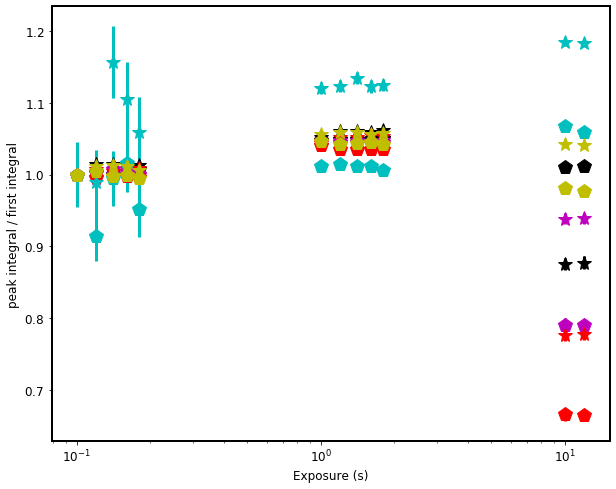

In [17]:
times   = [0.1, 1, 10] + [.1] * 4 + [1]*4 + [10]
times   = [0.1, 1, 10, 0.12, 0.14, 0.16, 0.18, 1.2, 1.4, 1.6, 1.8, 12]
colors  = "kmrcybg"
markers = "p*"

data = filter_df(experiment.pre.crystals, ex_wl=ex_wl, grating=2, crystal_type="CaF")
for color, (crystal_id, crystal) in zip(colors, data.groupby("crystal_id")):
    ii, ee = get_integrals(crystal, em_wl)

    for marker, i, e in zip(markers, ii, ee):
        plt.errorbar(times, i/i[0], e/i[0], fmt=marker + color)
#        plt.errorbar(times, i, e, fmt=marker + color)
    
plt.xscale("log")
plt.xlabel("Exposure (s)")
plt.ylabel("peak integral / first integral")

In [18]:
pre  = experiment.pre 
post = experiment.post
ints = defaultdict(lambda: defaultdict(dict))
poss = defaultdict(lambda: defaultdict(dict))

k  = 0
for crystal_id, crystal in sorted(pre.crystals.groupby("crystal_id")):
    if "CaF" not in crystal_id: continue
    k += 1
    for when in "pre post".split():
        meas   = globals()[when]
        df     = meas.crystals
        pos    = find_crystal_position(crystal_id, meas.metadata)
        caf    = filter_df(df, ex_wl=ex_wl, grating=2, crystal_id=crystal_id)
        ii, ee = get_integrals(caf, em_wl)
        
        poss[crystal_id][when] = pos
        for la, i, e in zip((False, True), ii, ee):
            ints[crystal_id][when][la] = i, e

# Without position correction

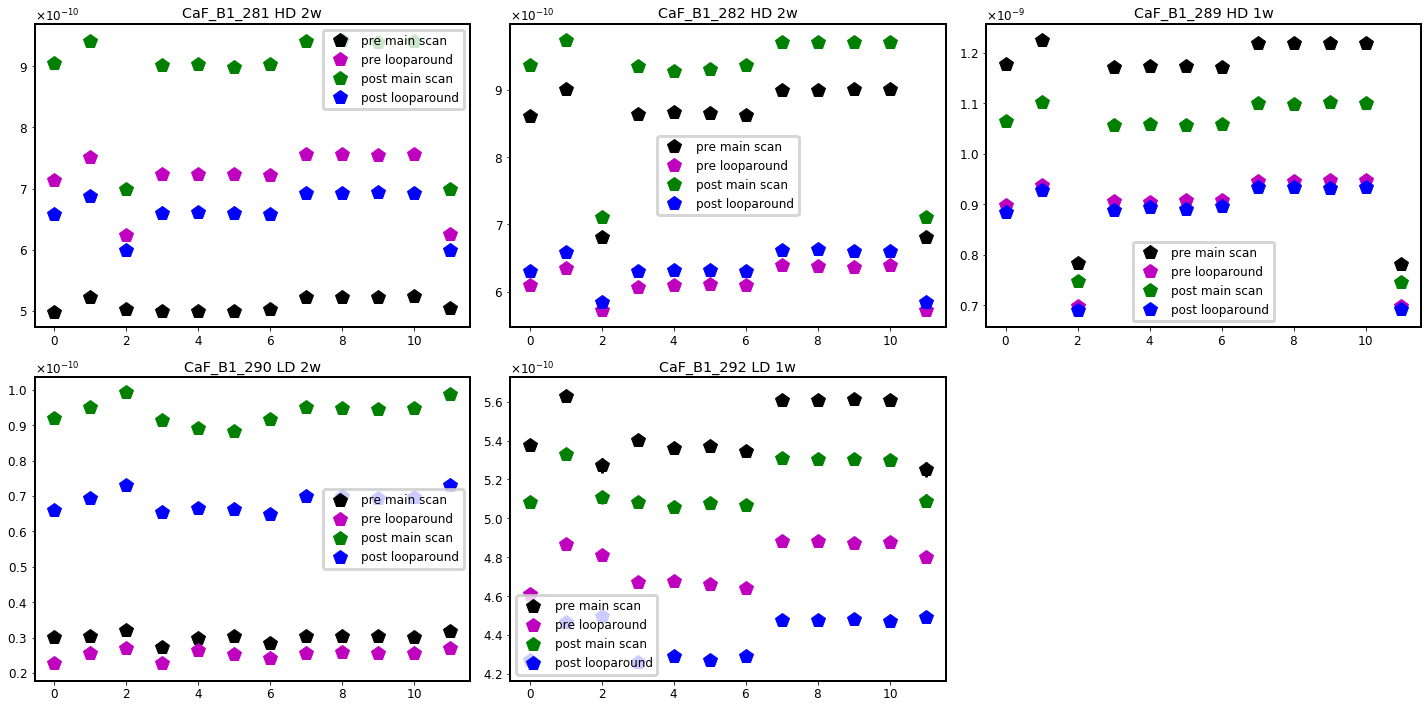

In [19]:
plt.figure(figsize=(20, 10))

k  = 0
for crystal_id, crystal in sorted(ints.items()):
    k += 1
    plt.subplot(2, 3, k)
    for when, loops in crystal.items():
        for la, (i, e) in loops.items():
            scan = "looparound" if la else "main scan"
            plt.errorbar(np.arange(len(i)), i, e, fmt="p", label=f"{when} {scan}")
    where = californication_irradiation_mapping[crystal_id]
    plt.title(f"{crystal_id} {where}")
    plt.ylim()
    plt.legend()
plt.tight_layout()

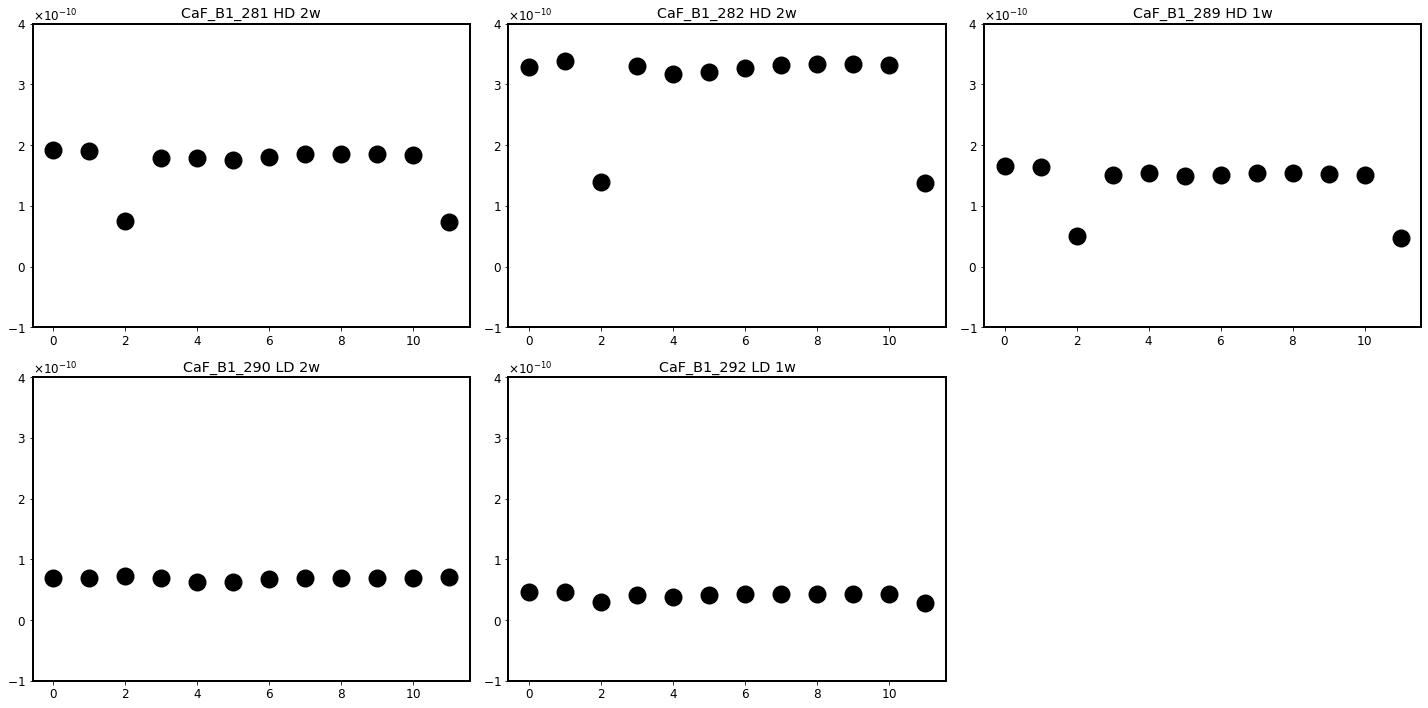

In [20]:
plt.figure(figsize=(20, 10))

k  = 0
for crystal_id, crystal in sorted(ints.items()):
    k += 1
    plt.subplot(2, 3, k)
    diff = np.array(crystal["post"][False][0]) - np.array(crystal["pre"][True][0])
    plt.scatter(np.arange(len(diff)), diff)
    where = californication_irradiation_mapping[crystal_id]
    plt.title(f"{crystal_id} {where}")
    plt.ylim(-1e-10, 4e-10)
plt.tight_layout()

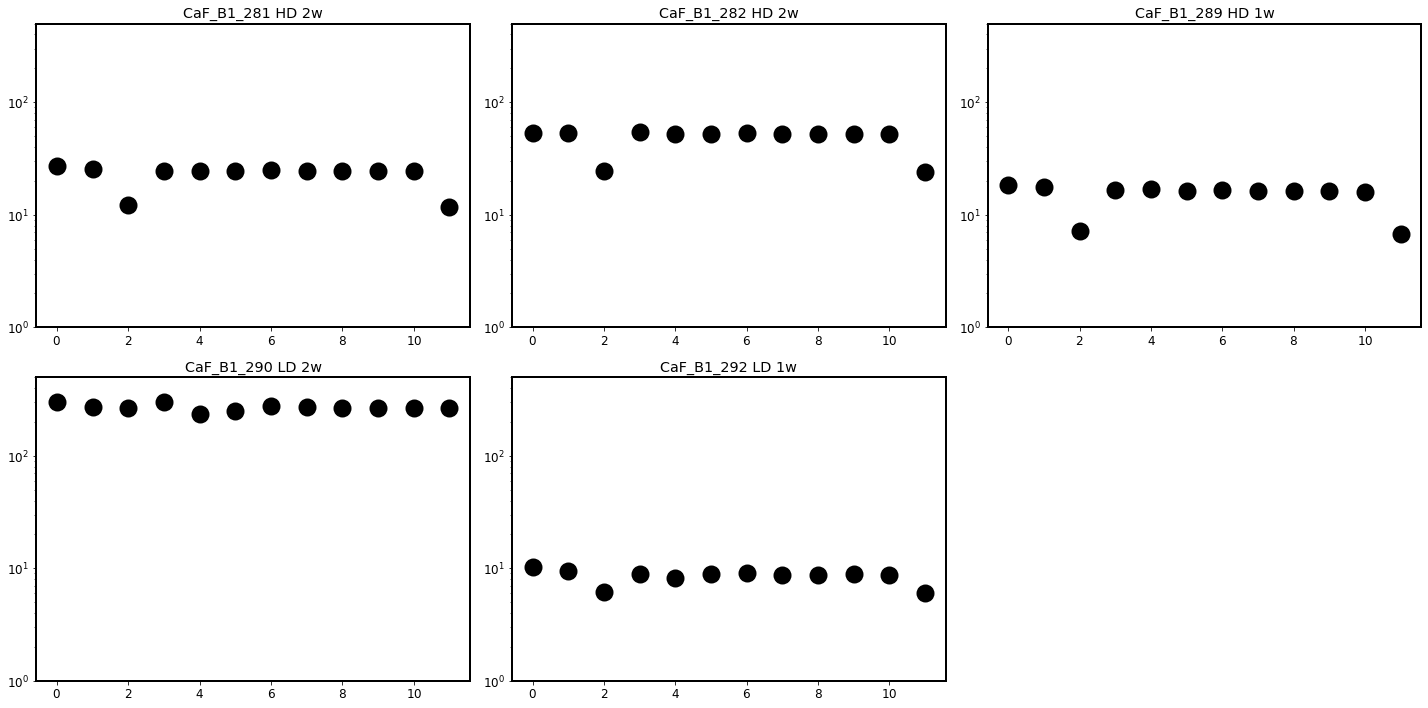

In [21]:
plt.figure(figsize=(20, 10))

k  = 0
for crystal_id, crystal in sorted(ints.items()):
    k += 1
    plt.subplot(2, 3, k)
    diff = 100 * np.array(crystal["post"][False][0]) / np.array(crystal["pre"][True][0]) - 100
    plt.scatter(np.arange(len(diff)), diff)
    where = californication_irradiation_mapping[crystal_id]
    plt.title(f"{crystal_id} {where}")
    plt.yscale("log")
    plt.ylim(1, 500)
plt.tight_layout()

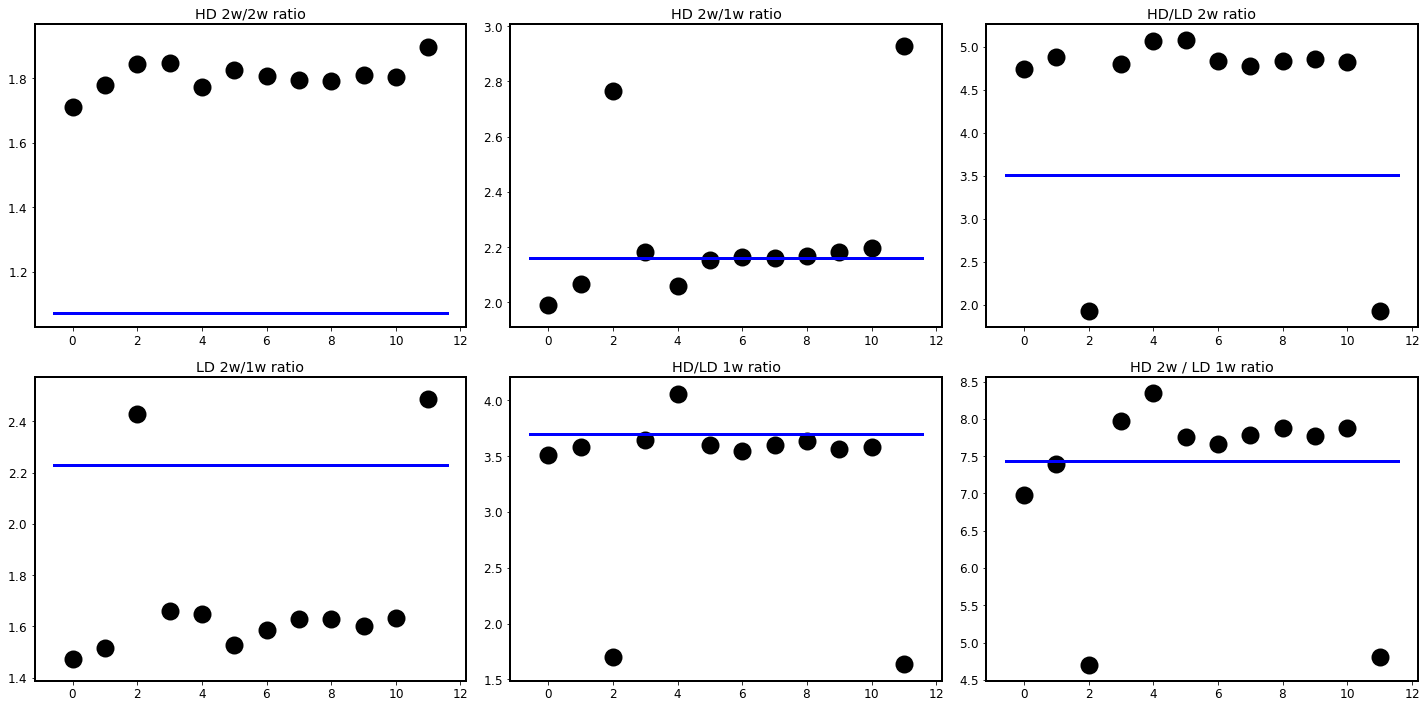

In [22]:
plt.figure(figsize=(20, 10))

ds = {}
for crystal_id, crystal in sorted(ints.items()):
    ds[crystal_id] = np.array(crystal["post"][False][0]) - np.array(crystal["pre"][True][0])


plt.subplot(2, 3, 1)
plt.scatter(np.arange(len(diff)), ds["CaF_B1_282"] / ds["CaF_B1_281"])
plot_line(1.07, axis="x", color="b")
#plot_line(1.05, axis="x", color="g")
plt.title(f"HD 2w/2w ratio")

plt.subplot(2, 3, 2)
plt.scatter(np.arange(len(diff)), ds["CaF_B1_282"] / ds["CaF_B1_289"])
plot_line(2.3 * 0.94, axis="x", color="b")
#plot_line(2.3 * 0.95, axis="x", color="g")
plt.title(f"HD 2w/1w ratio")

plt.subplot(2, 3, 3)
plt.scatter(np.arange(len(diff)), ds["CaF_B1_282"] / ds["CaF_B1_290"])
plot_line(3.51, axis="x", color="b")
#plot_line(1.14, axis="x", color="g")
plt.title(f"HD/LD 2w ratio")

plt.subplot(2, 3, 4)
plt.scatter(np.arange(len(diff)), ds["CaF_B1_290"] / ds["CaF_B1_292"])
plot_line(2.3 * 0.97, axis="x", color="b")
#plot_line(2.3 * 0.92, axis="x", color="g")
plt.title(f"LD 2w/1w ratio")

plt.subplot(2, 3, 5)
plt.scatter(np.arange(len(diff)), ds["CaF_B1_289"] / ds["CaF_B1_292"])
plot_line(3.70, axis="x", color="b")
#plot_line(1.10, axis="x", color="g")
plt.title(f"HD/LD 1w ratio")


plt.subplot(2, 3, 6)
plt.scatter(np.arange(len(diff)), ds["CaF_B1_282"] / ds["CaF_B1_292"])
plot_line(2.3 * 3.23, axis="x", color="b")
#plot_line(1.10, axis="x", color="g")
plt.title(f"HD 2w / LD 1w ratio")

plt.tight_layout()

# With position correction

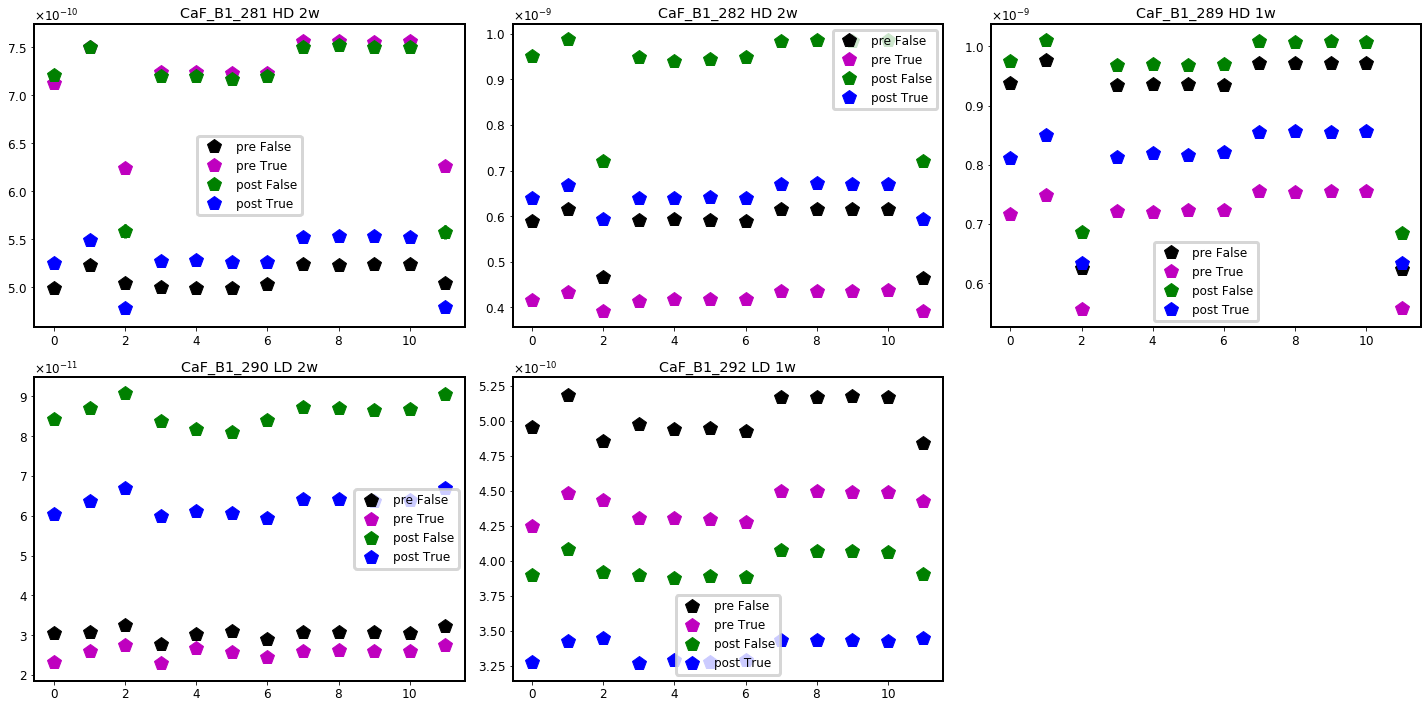

In [23]:
plt.figure(figsize=(20, 10))

k  = 0
for crystal_id, crystal in sorted(ints.items()):
    k += 1
    plt.subplot(2, 3, k)
    for when, loops in crystal.items():
        for la, (i, e) in loops.items():
            pos = poss[crystal_id][when]
            plt.errorbar(np.arange(len(i)), i * position_correction(pos), e, fmt="p", label=f"{when} {la}")
    where = californication_irradiation_mapping[crystal_id]
    plt.title(f"{crystal_id} {where}")
    plt.ylim()
    plt.legend()
plt.tight_layout()

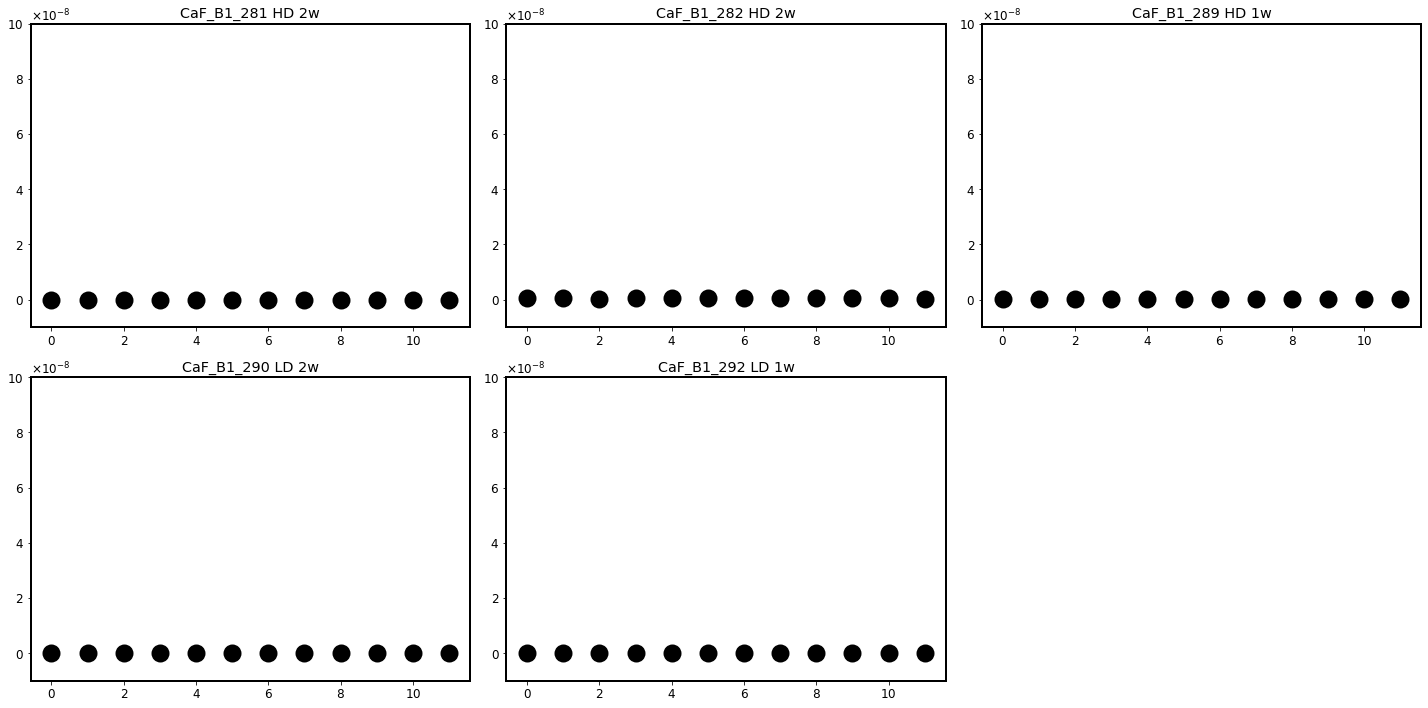

In [24]:
plt.figure(figsize=(20, 10))

k  = 0
for crystal_id, crystal in sorted(ints.items()):
    k += 1
    plt.subplot(2, 3, k)
    diff  = np.array(crystal["post"][False][0]) * position_correction(poss[crystal_id]["post"])
    diff -= np.array(crystal["pre" ][True ][0]) * position_correction(poss[crystal_id]["pre" ])
    plt.scatter(np.arange(len(diff)), diff)
    where = californication_irradiation_mapping[crystal_id]
    plt.title(f"{crystal_id} {where}")
    plt.ylim(-1e-8, 1e-7)
plt.tight_layout()

/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  


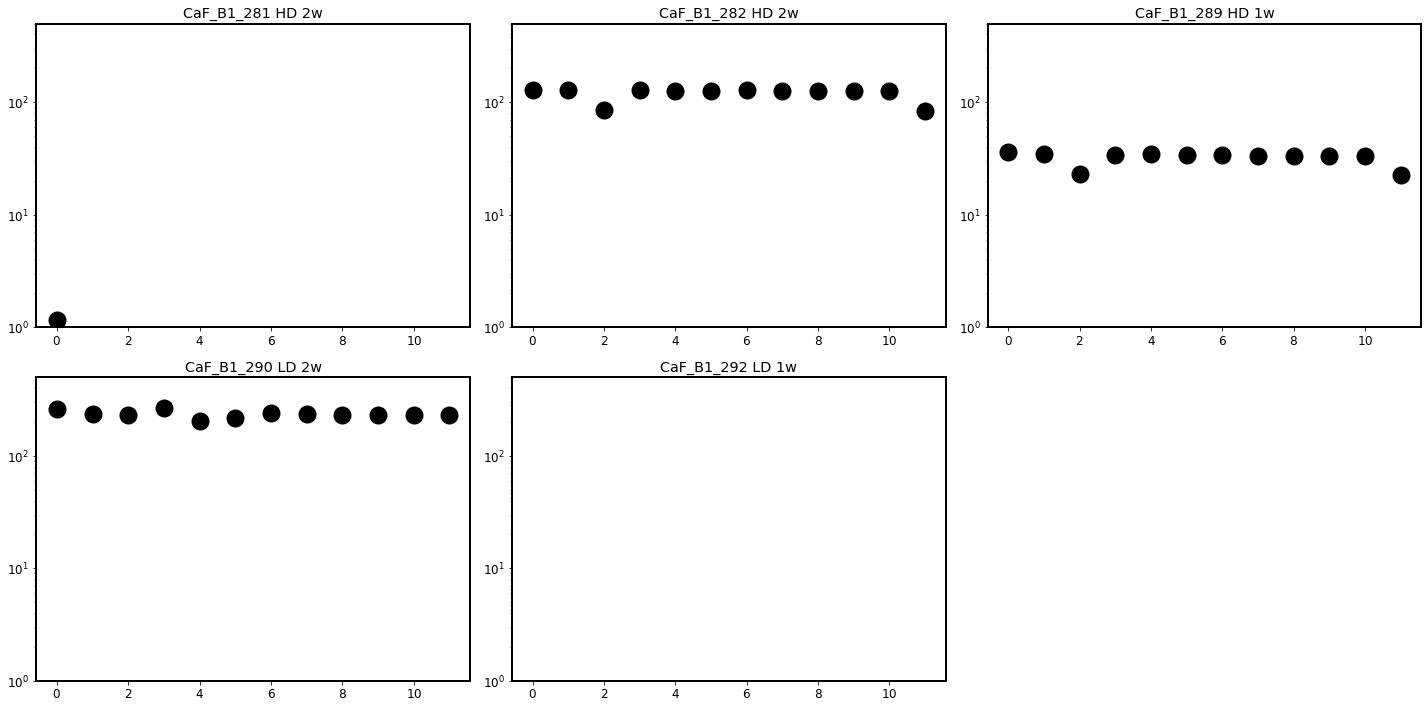

In [25]:
plt.figure(figsize=(20, 10))

k  = 0
for crystal_id, crystal in sorted(ints.items()):
    k += 1
    plt.subplot(2, 3, k)
    diff  = np.array(crystal["post"][False][0]) * position_correction(poss[crystal_id]["post"])
    diff /= np.array(crystal["pre" ][True][0]) * position_correction(poss[crystal_id]["pre" ])
    diff -= 1
    diff *= 100
    plt.scatter(np.arange(len(diff)), diff)
    where = californication_irradiation_mapping[crystal_id]
    plt.title(f"{crystal_id} {where}")
    plt.yscale("log")
    plt.ylim(1, 500)
plt.tight_layout()

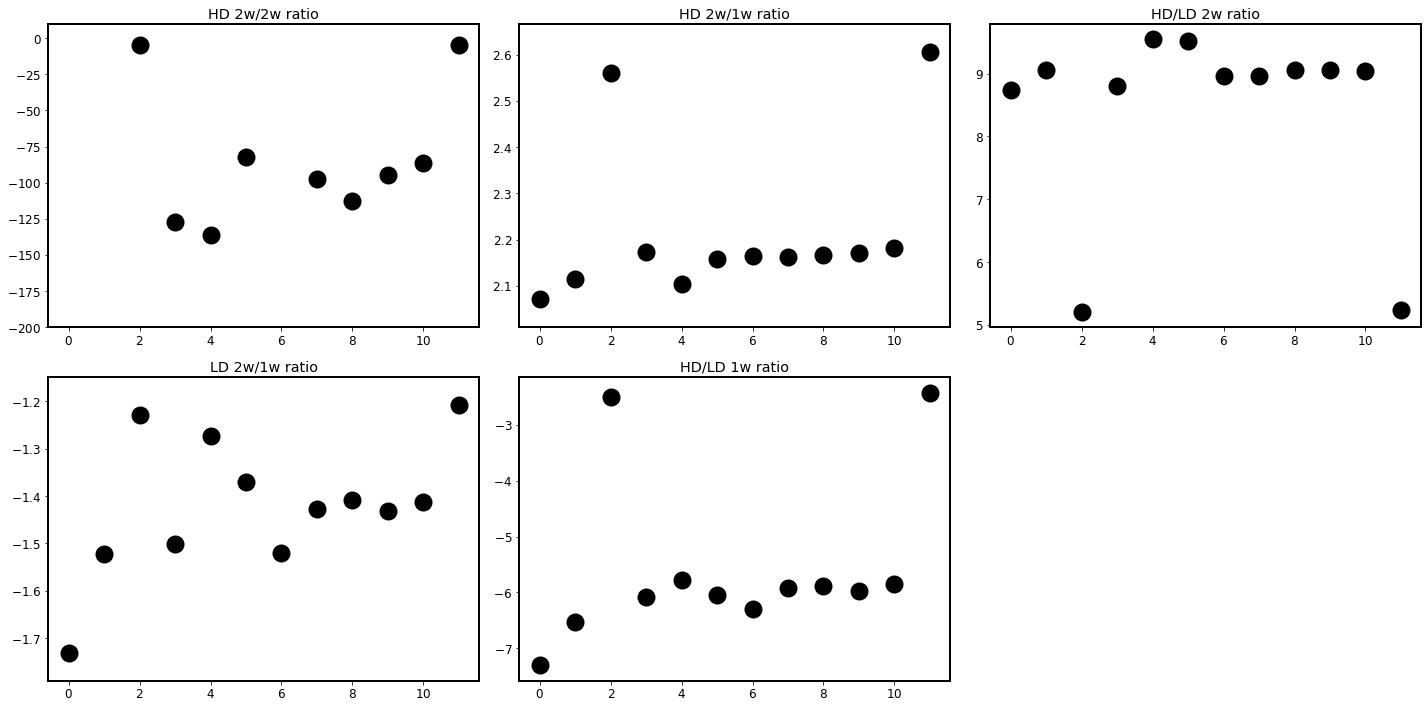

In [26]:
plt.figure(figsize=(20, 10))

ds = {}
for crystal_id, crystal in sorted(ints.items()):
    ds[crystal_id]  = np.array(crystal["post"][False][0]) * position_correction(poss[crystal_id]["post"])
    ds[crystal_id] -= np.array(crystal["pre" ][True ][0]) * position_correction(poss[crystal_id]["pre" ])


plt.subplot(2, 3, 1)
plt.scatter(np.arange(len(diff)), ds["CaF_B1_282"] / ds["CaF_B1_281"])
plt.title(f"HD 2w/2w ratio")
plt.ylim(-200, 10)

plt.subplot(2, 3, 2)
plt.scatter(np.arange(len(diff)), ds["CaF_B1_282"] / ds["CaF_B1_289"])
plt.title(f"HD 2w/1w ratio")

plt.subplot(2, 3, 3)
plt.scatter(np.arange(len(diff)), ds["CaF_B1_282"] / ds["CaF_B1_290"])
plt.title(f"HD/LD 2w ratio")

plt.subplot(2, 3, 4)
plt.scatter(np.arange(len(diff)), ds["CaF_B1_290"] / ds["CaF_B1_292"])
plt.title(f"LD 2w/1w ratio")

plt.subplot(2, 3, 5)
plt.scatter(np.arange(len(diff)), ds["CaF_B1_289"] / ds["CaF_B1_292"])
plt.title(f"HD/LD 1w ratio")


plt.tight_layout()